# Customer Segmentation using Bayesian Clustering

In this project, the goal is to perform customer segmentation based on several behavioral metrics. To achieve this, a Gaussian Mixture Model (GMM) is being used. GMM is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. It's a soft clustering method, meaning each data point (customer in this case) is assigned a probability for each cluster, representing the likelihood of the point belonging to that cluster. This allows for more nuanced cluster assignments, which can be useful when the boundaries between customer behaviors are not clear cut.

However, one challenge with GMMs is deciding the optimal number of Gaussian distributions (or clusters) to use. Too few, and the model might not capture the complexity in the data. Too many, and the model might overfit, capturing noise rather than underlying patterns. This is where the Bayesian Information Criterion (BIC) comes in. The BIC is a measure of the model's performance that balances the goodness of fit against the complexity of the model (number of clusters in this case). By calculating the BIC for GMMs with different numbers of clusters, you can choose the number that balances fit and simplicity most effectively. The model with the lowest BIC is selected as the best model. This approach systematically identifies the number of clusters that best represent the patterns in the customer data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

plt.style.use('ggplot')

In [2]:
DATA_DIRECTORY = 'dataset/csv'

aisles = pd.read_csv(
    os.path.join(DATA_DIRECTORY, 'aisles.csv')
    )

departments = pd.read_csv(
    os.path.join(DATA_DIRECTORY, 'departments.csv')
    )

order_products_prior = pd.read_csv(
    os.path.join(DATA_DIRECTORY, 'order_products__prior.csv')
    )
orders = pd.read_csv(
    os.path.join(DATA_DIRECTORY, 'orders.csv')
    )

products = pd.read_csv(
    os.path.join(DATA_DIRECTORY, 'products.csv')
                       )


# Preprocessing / Feature Engineering 

First, let's merge the dataframes together so that we have all the information we need in one place


In [3]:
# First, let's merge the dataframes together so that we have all the information we need in one place
order_products_prior = pd.merge(order_products_prior, products, on='product_id', how='left')
order_products_prior = pd.merge(order_products_prior, aisles, on='aisle_id', how='left')
order_products_prior = pd.merge(order_products_prior, departments, on='department_id', how='left')
orders_with_product_info = pd.merge(orders, order_products_prior, on='order_id', how='left')


**We can now aggregate the data at the customer level and create some features to segment our customers**
  - Number of orders
  - Average days between orders
  - Average basket size
  - Favourite department
  - Number of unique products purchased
  - Reordered ratio
  - Most frequently purchased product
  - Number of orders with no days since prior order
  - Time of day preference for ordering
  - Day of week preference for ordering

In [4]:
# Total number of orders
total_orders = orders.groupby('user_id')['order_number'].max().reset_index()
total_orders.columns = ['user_id', 'total_orders']
total_orders.head()

,user_id,total_orders
0,1,11
1,2,15
2,3,13
3,4,6
4,5,5


In [5]:
# Average days between orders
average_days_between_orders = orders.groupby('user_id')['days_since_prior_order'].mean().round(0).reset_index()
average_days_between_orders.columns = ['user_id', 'average_days_between_orders']
# average_days_between_orders['average_days_between_orders'] = average_days_between_orders['average_days_between_orders'].apply(lambda x: np.round(x,0))
average_days_between_orders.head()

,user_id,average_days_between_orders
0,1,19.0
1,2,16.0
2,3,12.0
3,4,17.0
4,5,12.0


In [6]:
# Average basket size
average_basket_size = orders_with_product_info.groupby(['user_id', 'order_id'])['product_id'].count().groupby('user_id').mean().round(0).reset_index()
average_basket_size.columns = ['user_id', 'average_basket_size']
average_basket_size.head()

,user_id,average_basket_size
0,1,5.0
1,2,13.0
2,3,7.0
3,4,3.0
4,5,7.0


In [7]:
# Favourite department

favorite_department = orders_with_product_info.groupby(['user_id', 'department'])['product_id'].count().reset_index()
favorite_department = favorite_department.sort_values(by=['user_id', 'product_id'], ascending=False).groupby(['user_id']).first().reset_index()[['user_id', 'department']]
favorite_department.columns = ['user_id', 'favorite_department']
favorite_department.head()

,user_id,favorite_department
0,1,snacks
1,2,dairy eggs
2,3,produce
3,4,beverages
4,5,produce


In [8]:
# Number of unique products ordered
unique_products = orders_with_product_info.groupby('user_id')['product_id'].nunique().reset_index()
unique_products.columns = ['user_id', 'unique_products']
unique_products.head()

,user_id,unique_products
0,1,18
1,2,102
2,3,33
3,4,17
4,5,23


In [9]:
# How often a customer order is a reorder
reorder_ratio = orders_with_product_info.groupby('user_id')['reordered'].mean().round(3).reset_index()
reorder_ratio.columns = ['user_id', 'reorder_ratio']
reorder_ratio.head()

,user_id,reorder_ratio
0,1,0.695
1,2,0.477
2,3,0.625
3,4,0.056
4,5,0.378


In [10]:
# Most frequently bought products
frequent_product = orders_with_product_info.groupby(['user_id', 'product_id'])['order_id'].count().reset_index()
frequent_product = frequent_product.sort_values(by=['user_id', 'order_id'], ascending=False).groupby(['user_id']).first().reset_index()[['user_id', 'product_id']]
frequent_product.columns = ['user_id', 'frequent_product_id']
frequent_product.head()

,user_id,frequent_product_id
0,1,196.0
1,2,32792.0
2,3,39190.0
3,4,35469.0
4,5,11777.0


In [11]:
# how often a customer orders multiple times a day
same_day_orders = orders[orders['days_since_prior_order'] == 0].groupby('user_id')['order_id'].count().reset_index()
same_day_orders.columns = ['user_id', 'same_day_orders']
same_day_orders.head()

,user_id,same_day_orders
0,1,1
1,4,1
2,17,1
3,24,1
4,27,7


In [12]:
order_hour_of_day = orders.groupby('user_id')['order_hour_of_day'].apply(lambda x: x.mode()[0]).reset_index()
order_hour_of_day.columns = ['user_id', 'average_order_hour_of_day']
order_hour_of_day.head()

,user_id,average_order_hour_of_day
0,1,7
1,2,10
2,3,16
3,4,11
4,5,18


In [13]:
order_day_of_week = orders.groupby('user_id')['order_dow'].apply(lambda x: x.mode()[0]).reset_index()
order_day_of_week.columns = ['user_id', 'average_order_day_of_week']
order_day_of_week.head()


,user_id,average_order_day_of_week
0,1,4
1,2,1
2,3,0
3,4,4
4,5,0


In [14]:
# List all the dataframes you created
dfs = [total_orders, average_days_between_orders, average_basket_size, 
       favorite_department, unique_products, reorder_ratio, 
       frequent_product, same_day_orders, order_hour_of_day, 
       order_day_of_week ]

# Use the reduce function to merge all dataframes
from functools import reduce

df_final = reduce(lambda left,right: pd.merge(left,right,on='user_id'), dfs)

# Check the result
df_final.head()

,user_id,total_orders,average_days_between_orders,average_basket_size,favorite_department,unique_products,reorder_ratio,frequent_product_id,same_day_orders,average_order_hour_of_day,average_order_day_of_week
0,1,11,19.0,5.0,snacks,18,0.695,196.0,1,7,4
1,4,6,17.0,3.0,beverages,17,0.056,35469.0,1,11,4
2,17,41,8.0,7.0,beverages,83,0.718,7350.0,1,12,1
3,24,19,15.0,2.0,beverages,18,0.526,31222.0,1,8,0
4,27,82,4.0,9.0,beverages,220,0.714,2966.0,7,14,2


We would like to pass this data in a mahcine learning model so we need to prepare it so the model can understand the data. <br> First we will normalize/standardize or data.

In [15]:
df_final = pd.get_dummies(df_final, columns=['favorite_department'])

# convert the columns from True/False to 1/0
cols_to_convert = [col for col in df_final.columns if col.startswith('favorite_department_')]
for col in cols_to_convert:
    df_final[col] = df_final[col].astype(int)

df_final

,user_id,total_orders,average_days_between_orders,average_basket_size,unique_products,reorder_ratio,frequent_product_id,same_day_orders,average_order_hour_of_day,average_order_day_of_week,...,favorite_department_frozen,favorite_department_household,favorite_department_international,favorite_department_meat seafood,favorite_department_other,favorite_department_pantry,favorite_department_personal care,favorite_department_pets,favorite_department_produce,favorite_department_snacks
0,1,11,19.0,5.0,18,0.695,196.0,1,7,4,...,0,0,0,0,0,0,0,0,0,1
1,4,6,17.0,3.0,17,0.056,35469.0,1,11,4,...,0,0,0,0,0,0,0,0,0,0
2,17,41,8.0,7.0,83,0.718,7350.0,1,12,1,...,0,0,0,0,0,0,0,0,0,0
3,24,19,15.0,2.0,18,0.526,31222.0,1,8,0,...,0,0,0,0,0,0,0,0,0,0
4,27,82,4.0,9.0,220,0.714,2966.0,7,14,2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33212,206199,20,17.0,16.0,134,0.590,24708.0,1,13,2,...,0,0,0,0,0,0,0,0,0,1
33213,206200,24,9.0,12.0,95,0.659,47209.0,2,19,1,...,0,0,0,0,0,0,0,0,1,0
33214,206201,33,11.0,12.0,174,0.569,23909.0,1,15,0,...,0,0,0,0,0,0,0,0,0,0
33215,206206,68,4.0,4.0,150,0.474,38530.0,5,18,0,...,1,0,0,0,0,0,0,0,0,0


In [16]:
df_final.columns

Index(['user_id', 'total_orders', 'average_days_between_orders',
       'average_basket_size', 'unique_products', 'reorder_ratio',
       'frequent_product_id', 'same_day_orders', 'average_order_hour_of_day',
       'average_order_day_of_week', 'favorite_department_alcohol',
       'favorite_department_babies', 'favorite_department_bakery',
       'favorite_department_beverages', 'favorite_department_breakfast',
       'favorite_department_bulk', 'favorite_department_canned goods',
       'favorite_department_dairy eggs', 'favorite_department_deli',
       'favorite_department_dry goods pasta', 'favorite_department_frozen',
       'favorite_department_household', 'favorite_department_international',
       'favorite_department_meat seafood', 'favorite_department_other',
       'favorite_department_pantry', 'favorite_department_personal care',
       'favorite_department_pets', 'favorite_department_produce',
       'favorite_department_snacks'],
      dtype='object')

In [17]:
df_columns_dist = ['total_orders', 'average_days_between_orders',
                   'average_basket_size', 'unique_products', 'reorder_ratio',
                   'same_day_orders', 'average_order_hour_of_day',
                   'average_order_day_of_week']

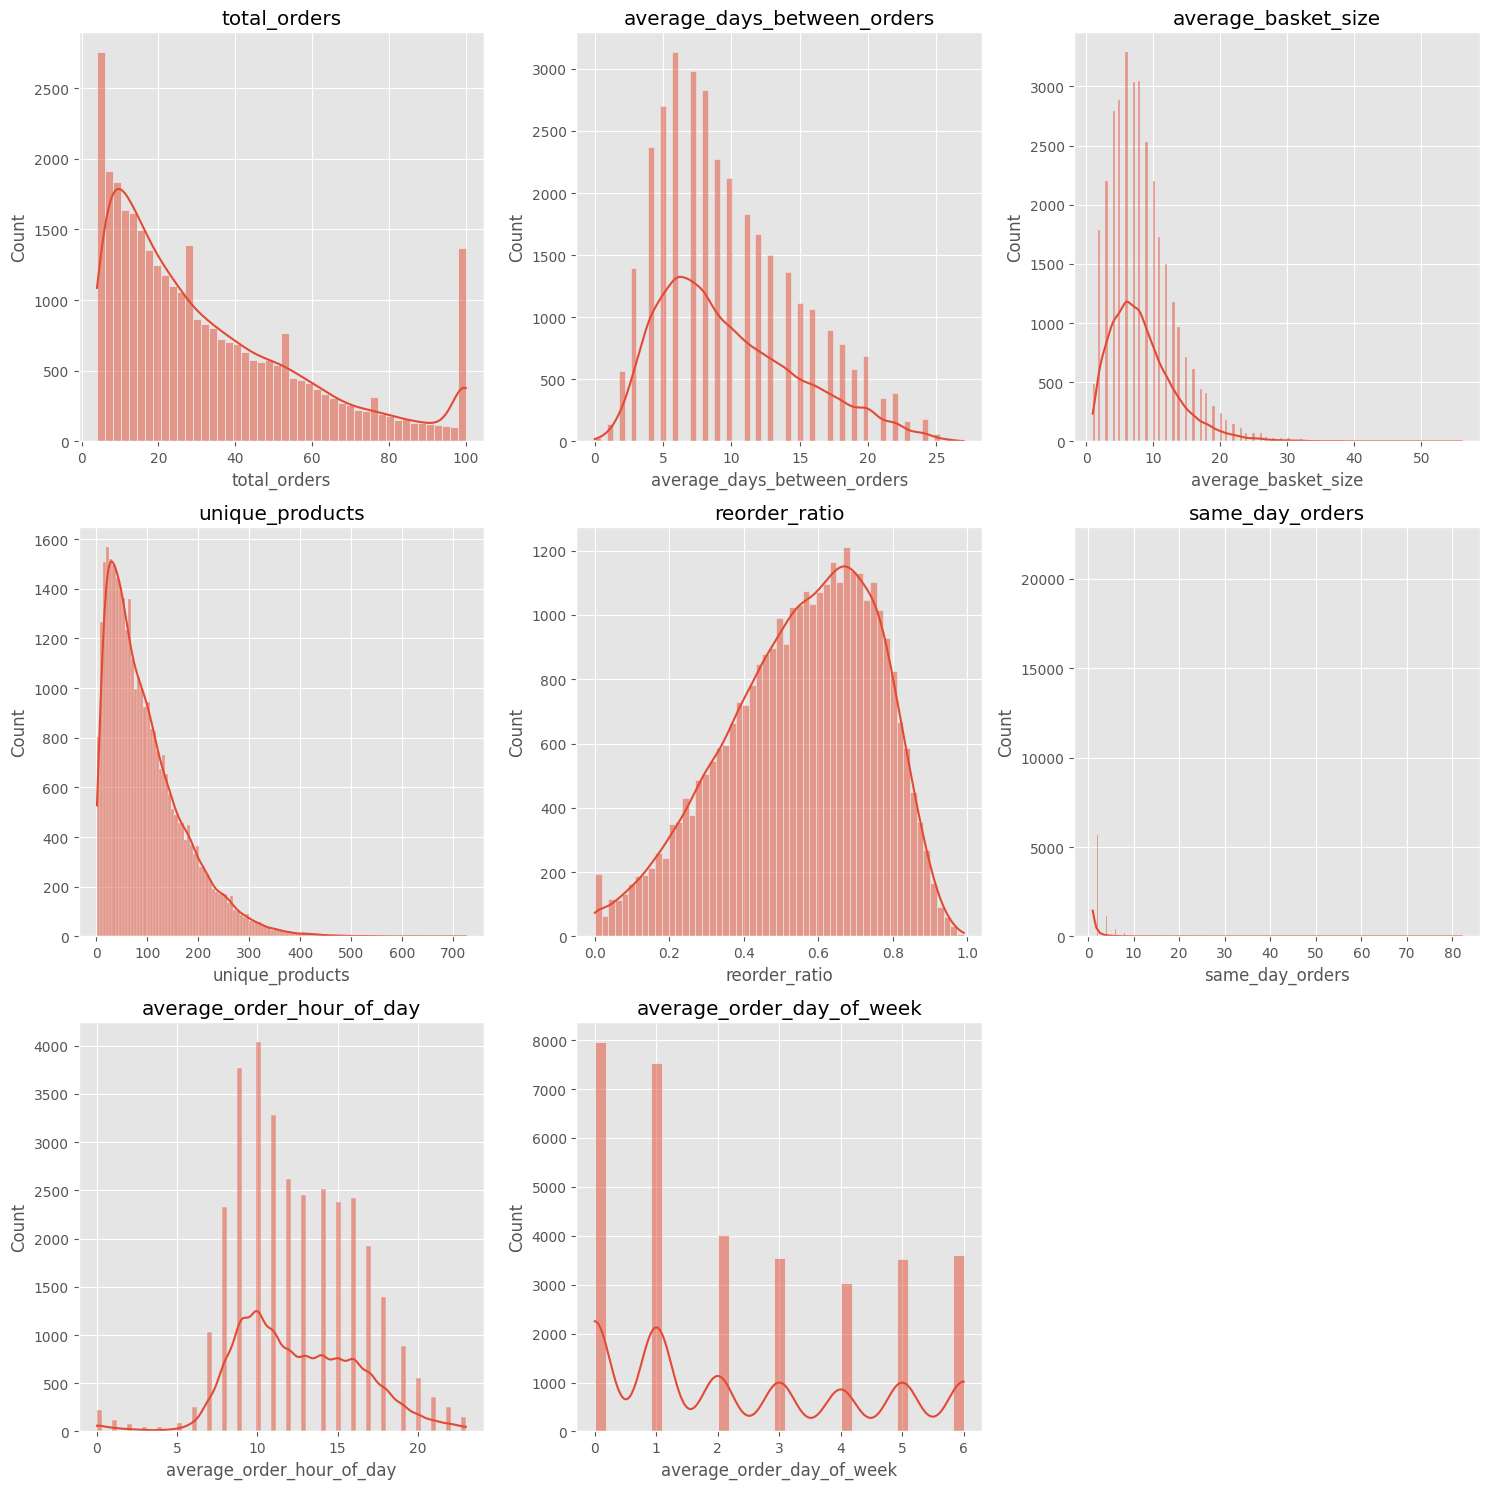

In [18]:

fig, axs = plt.subplots(3, 3, figsize=(15,15))

# Flatten the axes so we can easily iterate over them
axs = axs.flatten()

# Plot a histogram with a KDE for each column
for i, column in enumerate(df_columns_dist):
    sns.histplot(df_final[column], bins='auto', kde=True, ax=axs[i])
    axs[i].set_title(column)

# If the number of columns is less than 9, we can remove the extra subplots
if len(df_columns_dist) < 9:
    for i in range(len(df_columns_dist), 9):
        fig.delaxes(axs[i])

plt.tight_layout()
plt.show()


In [19]:
# Add a small constant to avoid taking log of zero
df_final['same_day_orders'] = np.log(df_final['same_day_orders'] + 1)

In [20]:
from sklearn.preprocessing import MinMaxScaler

# Create a scaler object
scaler = MinMaxScaler()

# Fit and transform the data
df_normalized = pd.DataFrame(scaler.fit_transform(df_final.drop('user_id', axis=1)), 
                             columns=df_final.columns[1:], index=df_final.index)

df_normalized.head()

,total_orders,average_days_between_orders,average_basket_size,unique_products,reorder_ratio,frequent_product_id,same_day_orders,average_order_hour_of_day,average_order_day_of_week,favorite_department_alcohol,...,favorite_department_frozen,favorite_department_household,favorite_department_international,favorite_department_meat seafood,favorite_department_other,favorite_department_pantry,favorite_department_personal care,favorite_department_pets,favorite_department_produce,favorite_department_snacks
0,0.072917,0.703704,0.072727,0.023448,0.702020,0.003925,0.00000,0.304348,0.666667,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.020833,0.629630,0.036364,0.022069,0.056566,0.713900,0.00000,0.478261,0.666667,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.385417,0.296296,0.109091,0.113103,0.725253,0.147921,0.00000,0.521739,0.166667,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.156250,0.555556,0.018182,0.023448,0.531313,0.628417,0.00000,0.347826,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.812500,0.148148,0.145455,0.302069,0.721212,0.059680,0.37209,0.608696,0.333333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


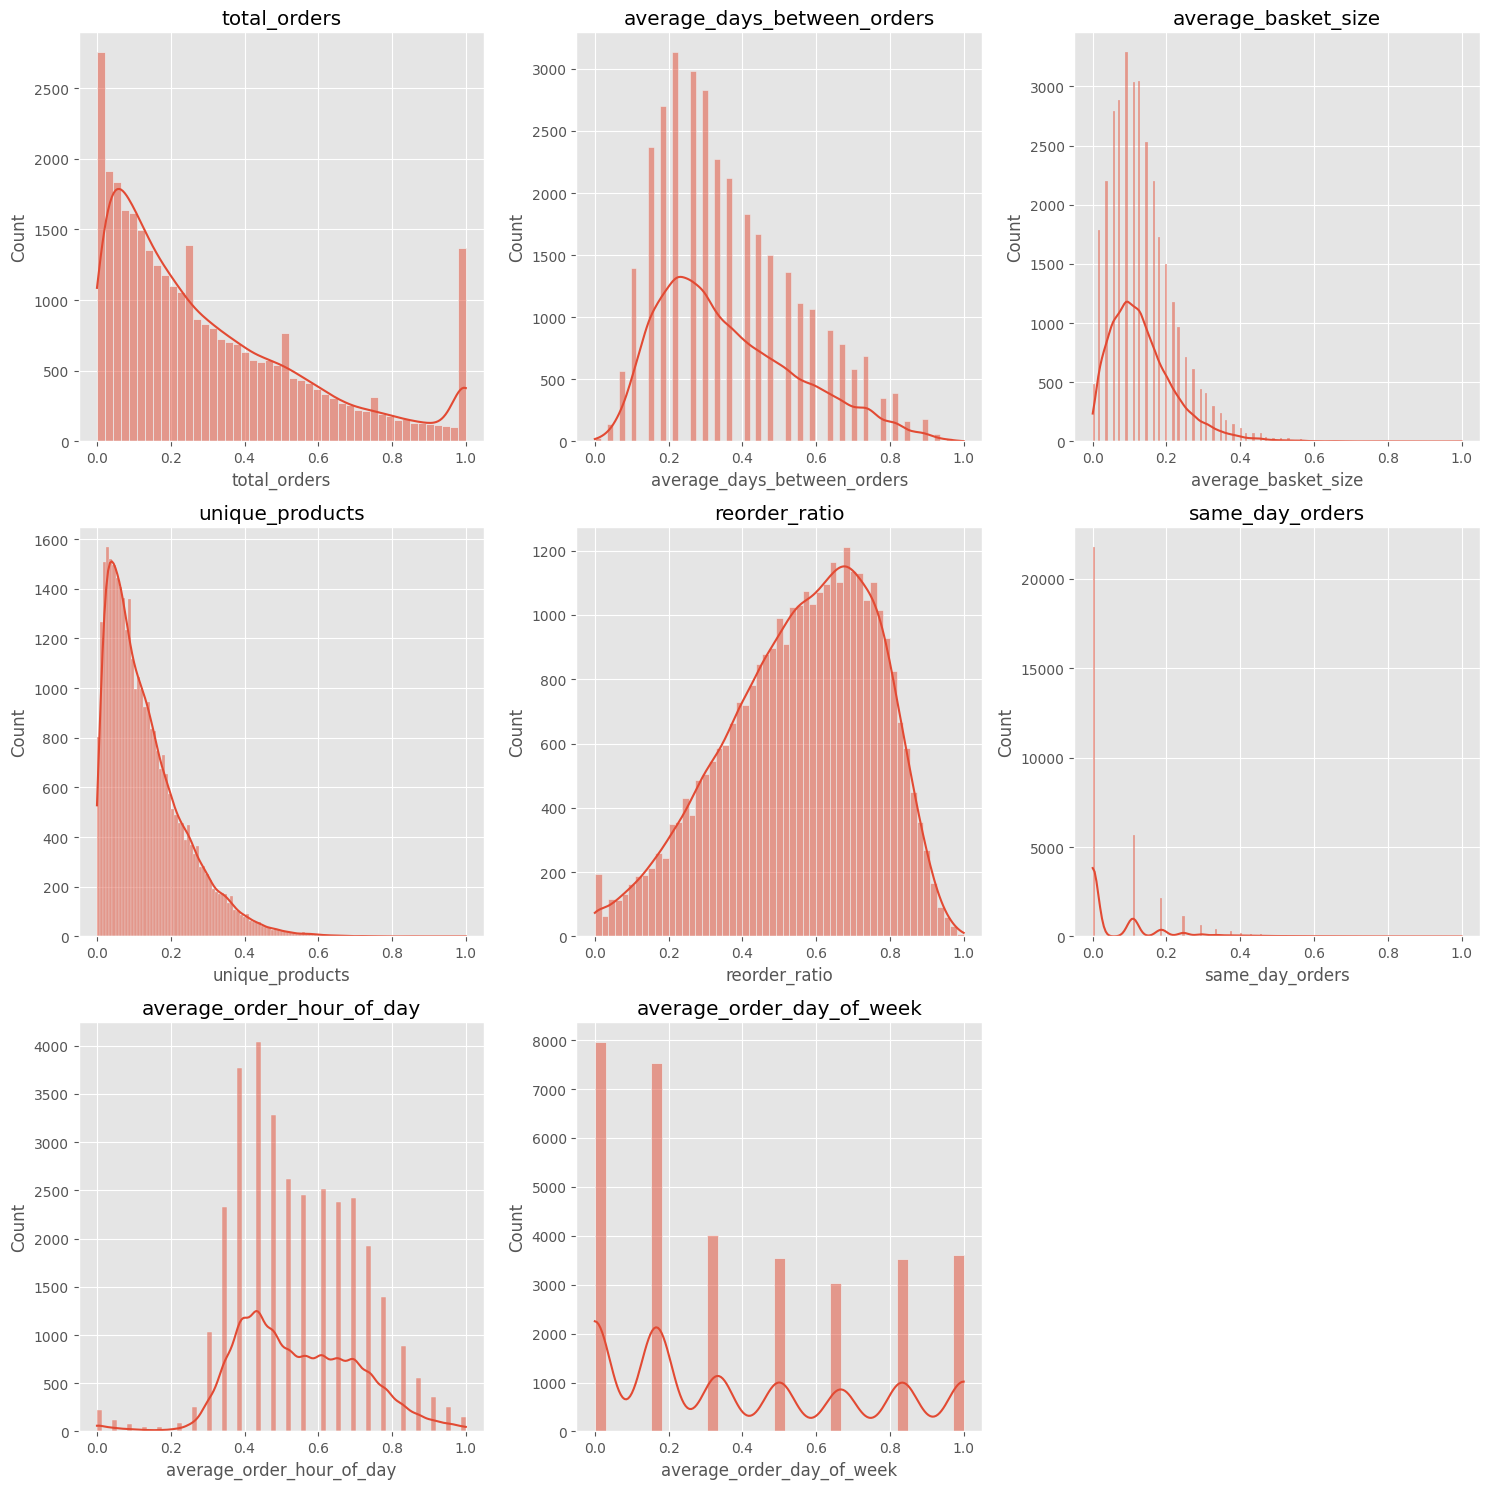

In [21]:
fig, axs = plt.subplots(3, 3, figsize=(15,15))

# Flatten the axes so we can easily iterate over them
axs = axs.flatten()

# Plot a histogram with a KDE for each column
for i, column in enumerate(df_columns_dist):
    sns.histplot(df_normalized[column], bins='auto', kde=True, ax=axs[i])
    axs[i].set_title(column)

# If the number of columns is less than 9, we can remove the extra subplots
if len(df_columns_dist) < 9:
    for i in range(len(df_columns_dist), 9):
        fig.delaxes(axs[i])

plt.tight_layout()
plt.show()


# Fit Model
Now our data is ready to pass through to our model.

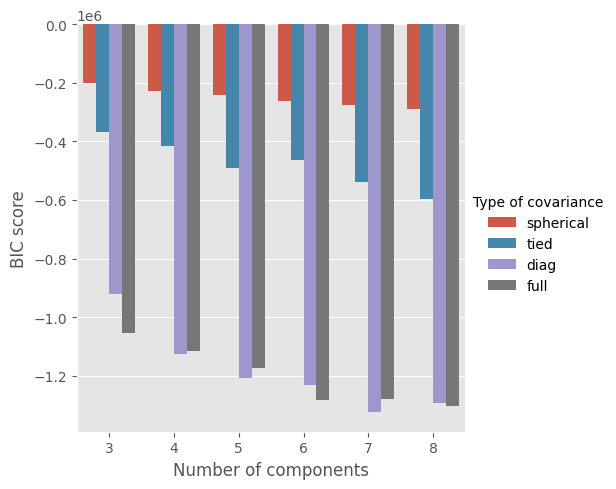

In [22]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from matplotlib.patches import Ellipse
from scipy import linalg
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)

# exclude 'user_id' and 'frequent_product_id'
# df_normalized = df_normalized.drop(columns=['user_id', 'frequent_product_id'])

param_grid = {
    "n_components": range(3, 9),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}
grid_search = GridSearchCV(
    GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
)
grid_search.fit(df_normalized)

# Plot the BIC scores
df = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
df["mean_test_score"] = -df["mean_test_score"]
df = df.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)

sns.catplot(
    data=df,
    kind="bar",
    x="Number of components",
    y="BIC score",
    hue="Type of covariance",
)
plt.show()


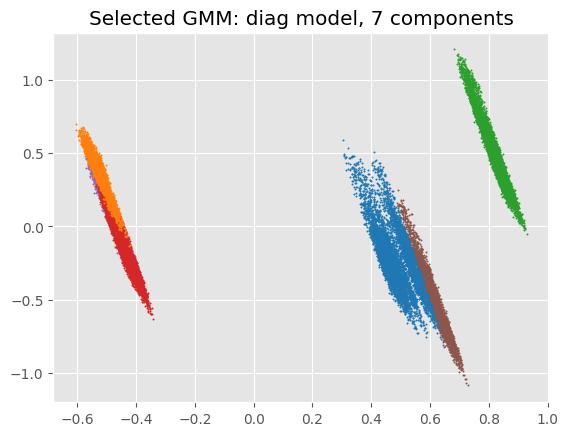

In [23]:
# Plot the best model
color_iter = sns.color_palette("tab10", grid_search.best_params_['n_components'])[::-1]

from sklearn.decomposition import PCA

# Perform PCA to reduce to 2 dimensions so we can visualize the clusters
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_normalized)


Y_ = grid_search.predict(df_normalized)
fig, ax = plt.subplots()

for i, color in enumerate(color_iter):
    if not np.any(Y_ == i):
        continue
    plt.scatter(df_pca[Y_ == i, 0], df_pca[Y_ == i, 1], 0.8, color=color)

plt.title(
    f"Selected GMM: {grid_search.best_params_['covariance_type']} model, "
    f"{grid_search.best_params_['n_components']} components"
)
plt.show()

In [74]:
labels = grid_search.best_estimator_.predict(df_normalized)
clustered_data = df_normalized.copy()

# Denormalize the data
clustered_data = scaler.inverse_transform(clustered_data)

# Convert back to a dataframe
clustered_data = pd.DataFrame(clustered_data, columns=df_normalized.columns)

# Assign the labels
clustered_data['Cluster'] = labels
# clustered_data = clustered_data.reset_index()
# Now, you can calculate the centroids
centroids = clustered_data.groupby('Cluster').mean()


In [78]:
# Calculate the mode for 'average_order_hour_of_day' and 'average_order_day_of_week'
hour_mode = clustered_data.groupby('Cluster')['average_order_hour_of_day'].agg(lambda x: x.round().mode()[0]).reset_index()
day_mode = clustered_data.groupby('Cluster')['average_order_day_of_week'].agg(lambda x: x.round().mode()[0]).reset_index()
# top_product = clustered_data.groupby('Cluster')['frequent_product_id'].agg(lambda x: x.mode()[0]).reset_index()

# Calculate the mean for all other columns
average_columns = clustered_data.drop(columns=['average_order_hour_of_day', 'average_order_day_of_week', 'frequent_product_id']).groupby('Cluster').mean().reset_index()

# Merge all the dataframes together
summary = average_columns.merge(hour_mode, on='Cluster').merge(day_mode, on='Cluster')
summary

,Cluster,total_orders,average_days_between_orders,average_basket_size,unique_products,reorder_ratio,same_day_orders,favorite_department_alcohol,favorite_department_babies,favorite_department_bakery,...,favorite_department_international,favorite_department_meat seafood,favorite_department_other,favorite_department_pantry,favorite_department_personal care,favorite_department_pets,favorite_department_produce,favorite_department_snacks,average_order_hour_of_day,average_order_day_of_week
0,0,26.562215,9.073256,8.092885,87.997897,0.536271,1.208131,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,10.0,0.0
1,1,28.827468,10.455310,6.278729,66.333230,0.547496,0.964331,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,10.0,1.0
2,2,54.813026,6.348119,12.132510,188.176867,0.689846,1.079668,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,9.0,0.0
3,3,22.320943,11.450600,9.185416,82.653980,0.509391,0.693147,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,10.0,0.0
4,4,33.759398,9.801345,8.378710,95.541551,0.558258,0.954943,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,9.0,1.0
5,5,81.102564,4.066793,9.064577,186.428933,0.732543,1.580570,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,9.0,1.0
6,6,26.228779,10.742983,6.867095,70.613629,0.495829,0.937775,0.091985,0.03162,0.030944,...,0.002029,0.009807,0.000169,0.089618,0.023504,0.009131,0.0,0.361008,10.0,1.0


In [82]:
pd.set_option('display.max_columns', None)
display(summary)

,Cluster,total_orders,average_days_between_orders,average_basket_size,unique_products,reorder_ratio,same_day_orders,favorite_department_alcohol,favorite_department_babies,favorite_department_bakery,favorite_department_beverages,favorite_department_breakfast,favorite_department_bulk,favorite_department_canned goods,favorite_department_dairy eggs,favorite_department_deli,favorite_department_dry goods pasta,favorite_department_frozen,favorite_department_household,favorite_department_international,favorite_department_meat seafood,favorite_department_other,favorite_department_pantry,favorite_department_personal care,favorite_department_pets,favorite_department_produce,favorite_department_snacks,average_order_hour_of_day,average_order_day_of_week
0,0,26.562215,9.073256,8.092885,87.997897,0.536271,1.208131,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,10.0,0.0
1,1,28.827468,10.455310,6.278729,66.333230,0.547496,0.964331,0.000000,0.00000,0.000000,1.0,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,10.0,1.0
2,2,54.813026,6.348119,12.132510,188.176867,0.689846,1.079668,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,9.0,0.0
3,3,22.320943,11.450600,9.185416,82.653980,0.509391,0.693147,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,10.0,0.0
4,4,33.759398,9.801345,8.378710,95.541551,0.558258,0.954943,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,1.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,9.0,1.0
5,5,81.102564,4.066793,9.064577,186.428933,0.732543,1.580570,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,9.0,1.0
6,6,26.228779,10.742983,6.867095,70.613629,0.495829,0.937775,0.091985,0.03162,0.030944,0.0,0.017416,0.000676,0.015387,0.0,0.01674,0.010315,0.216097,0.073554,0.002029,0.009807,0.000169,0.089618,0.023504,0.009131,0.0,0.361008,10.0,1.0


> - This information can be used to inform marketing strategies, product development, and other business decisions. For example, we might decide to target advertising to different clusters differently.
> - This could also be used as a feature in a predictive model. For example, if we're trying to predict customer churn, we might include the customer's cluster as a feature in yourour model.

**Some simple insights that can be inferred:** <br>
- **High frequency buyers:** Cluster 5 has the highest average number of total orders (81.1) and the shortest average days between orders (4.07). <br> This suggests that this cluster represents customers who purchase very frequently from the store.

- **Large basket size:** Cluster 2 has the highest average basket size (12.13) and also has a high number of unique products (188.18). This could <br> represent customers who tend to buy a wide variety of items and make large purchases each time they shop.

- **Preference for certain departments:** For clusters 0, 2, 3, and 5, 'favorite_department_produce',<br> is 1. This suggests that these clusters primarily buy from the produce department. On the other hand, cluster 6 shows some diversity in their shopping habits, with non-zero values in several 'favorite_department' columns, <br> suggesting that they purchase from a variety of departments.

- **Day of the week preference:** Customers in clusters 0, 2, 3, and 5 seem to prefer ordering on the 0th day of the week (Sunday),<br> whereas customers in clusters 1, 4, and 6 seem to prefer ordering on the Monday.

- **Reorder habits:** Cluster 5 also has the highest reorder ratio (0.73), which suggests that these customers often buy the same products in each order.